# Categorisez automatiquement des questions - Exploration

In [1]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/drive')

skipping


# SOMMAIRE
* [PREPARATION](#PREPARATION)
* [CHARGEMENT](#CHARGEMENT)
* [Monogram](#Monogram)
    * [BAG OF WORDS](#BAG-OF-WORDS)
    * [TF-IDF](#TF-IDF)
        * [Bodies](#Bodies)
        * [Titles](#Titles)
        * [Pondere](#Pondere)
        * [Bodies+titles](#Bodies+titles)
    * [REDUCTION DIMENSIONNELLE - ACP](#REDUCTION-DIMENSIONNELLE---ACP)
    * [CLUSTERING](#CLUSTERING)
* [Bi-grams](#Bi-grams)
* [Tri-grams](#Tri-grams)
*[Tags](#Tags)
    * [Classement-TF-IDF](#Tags)
    * [Labellisation](#Labellisation)

# PREPARATION

## Import des librairies

In [2]:
import time

import joblib
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib import cm #colormap
import numpy as np

import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import cluster, metrics
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import r2_score, accuracy_score

from sklearn.manifold import TSNE

from collections import Counter

## Paramétrage du notebook

In [3]:
from matplotlib import font_manager

font_dirs = ['/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Comic Sans'
plt.rcParams['font.sans-serif'] = 'Franklin Gothic Book'

In [4]:
sns.set(rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

#mplt.font_manager._rebuild()
#mplt.font_manager.findfont('Franklin Gothic Book',rebuild_if_missing=True)


pd.options.display.max_colwidth=200
pd.options.display.min_rows=25
pd.options.display.max_columns=50

## Declaration des fonctions

In [5]:
def count_words(list):
    # create counter and run through all data
    counter = Counter()
    freq = Counter(list) 
    return freq

def bow(documents):
    cv=CountVectorizer()
    cv.fit(documents)
    vector=cv.transform(documents)
    dfBOW=pd.DataFrame(data=vector.toarray(),columns=cv.get_feature_names_out())
    return dfBOW
def confusionMatrixAcc(y_true, y_pred):
    """
    Fonction qui retourne la matrice de confusion

    Parameters
    ----------
    y_true : pandas Series
        une Serie de valeurs (labels) reelles
    y_pred : pandas Series
        une Serie de valeurs (labels) predites
    Returns
    -------
    confusionMatrix : DataFrame
        la matrice de confusion
    """

    dfConfusion=pd.crosstab(y_test, y_pred_test,rownames=['Reel'], colnames=['Predit'], margins=False)
    confusionMatrix=pd.DataFrame()

    for c in dfConfusion.columns:
        TP=dfConfusion.loc[c,c]
        FP=dfConfusion.loc[:,c].sum()-dfConfusion.loc[c,c]
        TN=np.diagonal(dfConfusion).sum()-dfConfusion.loc[c,c]
        FN=dfConfusion.loc[c,:].sum()-dfConfusion.loc[c,c]
        TPR=TP/(TP+FN) # taux de vrai positif
        FPR=FP/(FP+TN) # taux de faux positifs
        Accuracy=(TP+TN)/(TP+FP+TN+FN)
        confusionMatrix=pd.concat([confusionMatrix,
        pd.DataFrame({
            'Class':c,
            'TP':[TP],
            'FP':[FP],
            'TN':[TN],
            'FN':[FN],
            'TPR':[TPR],
            'FPR':[FPR],
            'Accuracy':[Accuracy]})
            ])
    
    confusionMatrix.reset_index(drop=True,inplace=True)
    confusionMatrix=confusionMatrix.sort_values('Accuracy',ascending=False)
    return confusionMatrix

def getClass(row):
    # no de colonne ayant le TFIDF max
    if row.max()==0: # TF IDF nul pour toute la ligne
        return -1
    else:
        tags=row.idxmax().split() #separation du bigramme
        print(tags)
        rowclass=tagclass.get(tags[0],-1)
        if rowclass<0:
            print('row negative')
            rowclass=tagclass.get(tags[1],-1)
        return rowclass

# CHARGEMENT

In [6]:
# Calculate the time elapsed in seconds
start = time.time()

In [7]:
#dfCleaned=joblib.load("drive/MyDrive/Colab Notebooks/Datasets/dfCleaned.jbl.bz2")
dfCleaned=joblib.load('dfCleaned2000.jbl.bz2')

In [8]:
dfCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 43576 to 48725
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        2000 non-null   object
 1   Body         2000 non-null   object
 2   Tags         2000 non-null   object
 3   BodyLemmas   2000 non-null   object
 4   TitleLemmas  2000 non-null   object
dtypes: object(5)
memory usage: 93.8+ KB


In [9]:
dfCleaned.sample(8)

,Title,Body,Tags,BodyLemmas,TitleLemmas
45442,scalatest in eclipse: running it gives nullpointer exception,"<p>edit: this issue was a bug with sbteclipse and has been <a href=""https://github.com/typesafehub/sbteclipse/issues/177"" rel=""nofollow"">fixed</a></p>\n\n<p>when i right click on a scalatest suite...",eclipse scalatest,"[edit, issue, bug, sbteclipse, href, http, github, com, typesafehub, sbteclipse, issue, rel, nofollow, fix, right, click, suite, select, run, file, get, nullpointer, exception, plugin, ide, jar, l...","[scalatest, eclipse, run, give, nullpointer, exception]"
22678,validating uploaded files server side,"<p>i have some csv files that i need uploaded to a site i'm writing in codeigniter. </p>\n\n<p>i need to validate the csv to make sure they contain various info, column counts match up and stuff l...",php codeigniter csv,"[csv, file, need, uplo, site, write, codeigniter, need, vali, csv, make, sure, contain, various, info, column, count, match, stuff, like, ci, sort, plugin, make, easy]","[validate, uploaded, file, server, side]"
18737,swift – uitabbar.appearance().bartintcolor not working in simulator,<p>here is my code:</p>\n\n<pre><code>import uikit\n\nclass tabbarviewcontroller: uitabbarcontroller {\n\n override func viewdidload() {\n super.viewdidload()\n uitabbar.appearanc...,ios swift uitabbarcontroller ios-simulator,"[code, import, uikit, class, uit, override, func, viewdidlo, super, viewdidlo, uit, appearance, uicolor, run, work, perfectly, real, device, set, color, correctly, code, run, iphone, simulator, re...","[swift, uitabbar, appearance, bartintcolor, work, simulator]"
39706,django create dates list from queryset,<p>i want to create a list of distinct month / year values based on a date fields in my db.\nso for example in my table i have</p>\n\n<p>id | date_added | title</p>\n\n<p>1 | 01/06/2010 | ????</p...,django,"[want, create, list, distinct, month, year, value, field, example, id, title, model, article, would, create, list, june, august, september, january]","[django, create, date, list, queryset]"
37586,item size not adjusted after font change in ctreectrl,"<p>i change the font of tree items in ctreectrl with the following code:</p>\n\n<pre><code>void ctreectrlex::onnmcustomdraw(nmhdr *pnmhdr, lresult *presult)\n{\n lpnmtvcustomdraw pnmcd = reinte...",c++ mfc treecontrol,"[change, font, tree, item, ctreectrl, follow, code, void, ctreectrlex, onnmcustomdraw, nmhdr, pnmhdr, lresult, presult, lpnmtvcustomdraw, pnm, presult, switch, pnm, nm, dwdrawstage, presult, retur...","[item, size, adjust, font, change, ctreectrl]"
15360,how to enable opencart seo url,<p>i am struggling with my open cart website from last 3 days. \ni am using opencart 2.3.0.2. seo url option is not working for me. \nbelow is the path for .htaccess file and opencart website file...,php .htaccess opencart url-routing opencart2.x,"[struggle, open, website, last, use, open, seo, url, option, work, path, ht, file, open, website, file, ht, path, var, www, open, uplo, appli, file, var, www, open, uplo, ht, file, rewriteengine, ...","[enable, opencart, seo, url]"
42542,perl modules: mysql vs dbi,"<p>a lot of our automated processes use perl and need to access our mysql dbs. i hate to admit it, but up until recently we haven't really done much benchmarking with the majority of our processe...",mysql perl performance module dbi,"[lot, automate, process, use, perl, need, mysql, hate, recently, really, do, much, benchmarking, majority, process, one, devs, setup, test, compare, performance, use, mysql, v, use, follow, pseudo...","[perl, module, mysql, v, dbi]"
13533,"""delay"" inclusion of separate file in php?","<p>at the very top of my page/site, before <code>&lt;!doctype html&gt;</code> etc., i load my classes with <code>spl_autoload_register()</code>.</p>\n\n<p>one of the classes is <code>site</code>, ...",php class,"[top, page, site, doctype, html, etc, lo, class, one, class, site, inside, class, static, function, php, fas

In [10]:
bodies=dfCleaned['BodyLemmas'].map(' '.join)
titles=dfCleaned['TitleLemmas'].map(' '.join)

# Pour tenir compte des titres, on les concatene aux corps de message
dfCleaned['BodyTitleLemmas']=dfCleaned['BodyLemmas']+dfCleaned['TitleLemmas']
bodies_titles=dfCleaned['BodyTitleLemmas'].map(' '.join)

In [11]:
# N premiers résultats à garder
N=30

# BAG OF WORDS

In [12]:
dfBowBodies=bow(bodies)
nBowBodies=dfBowBodies.to_numpy() # optimisation des calculs en passant par numpy

dfBowTitles=bow(titles)
nBowTitles=dfBowTitles.to_numpy() # optimisation des calculs en passant par numpy

In [13]:
%%time
dfSumBowBodies=pd.DataFrame(data=nBowBodies.sum(axis=0))
dfSumBowBodies.index=dfBowBodies.columns
dfSumBowBodies.columns=['count']

dfSumBowTitles=pd.DataFrame(data=nBowTitles.sum(axis=0))
dfSumBowTitles.index=dfBowTitles.columns
dfSumBowTitles.columns=['count']

dfSumBowTitlesHead=dfSumBowTitles.sort_values(by='count',ascending=False).head(N)
dfSumBowBodiesHead=dfSumBowBodies.sort_values(by='count',ascending=False).head(N)

CPU times: user 46.6 ms, sys: 21 ms, total: 67.6 ms
Wall time: 66.1 ms


In [14]:
from IPython.display import display_html 


df1_styler = dfSumBowTitlesHead.style.set_table_attributes("style='display:inline'").set_caption('dfSumBowTitlesHead')
df2_styler = dfSumBowBodiesHead.style.set_table_attributes("style='display:inline'").set_caption('dfSumBowBodiesHead')

space = "\xa0" * 10
display_html(df1_styler._repr_html_()+ space  + df2_styler._repr_html_(), raw=True)

,count
use,202
file,122
get,99
error,85
value,73
work,68
array,65
string,64
android,61
data,59


# Monogram

## TF-IDF

In [15]:
# Initialisation du vectoriseur TF IDF de scikit learn
vectorizer= TfidfVectorizer()

### Bodies

In [16]:
response= vectorizer.fit_transform(bodies)
dfTFIDF_bodies=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies=dfTFIDF_bodies.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - bodies classement des mots')]

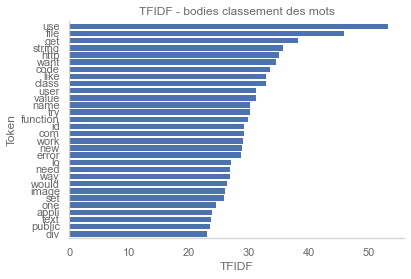

In [17]:
ax = sortedTFIDF_bodies.head(N).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - bodies classement des mots')

### Titles

In [18]:
%%time
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

CPU times: user 50.1 ms, sys: 12.7 ms, total: 62.8 ms
Wall time: 61 ms


[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - titles - classement des mots')]

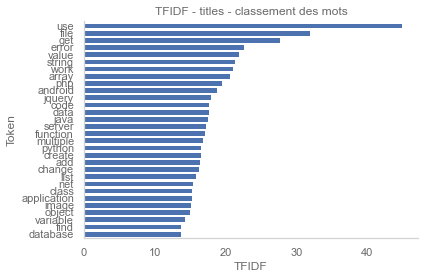

In [19]:
ax = sortedTFIDF_titles.head(N).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - titles - classement des mots')

In [20]:
dfTFIDF_titles.shape,dfTFIDF_bodies.shape

((2000, 3044), (2000, 14975))

### Pondere

TF-IDF (Pondéré) = TF-IDF(title) * alpha + TF-IDF(body) * (1-alpha)  
par ex. avec alpha=0.8

In [21]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_bodies.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_bodies[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

In [22]:
dfTFIDFCommon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2296 entries, split to argsort
dtypes: float64(2296)
memory usage: 35.0 MB


<AxesSubplot:>

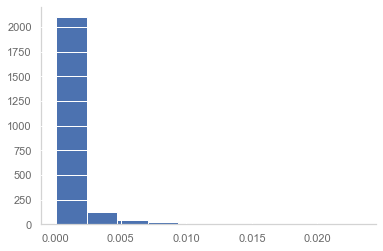

In [23]:
dfTFIDFCommon.mean(axis=0).hist()

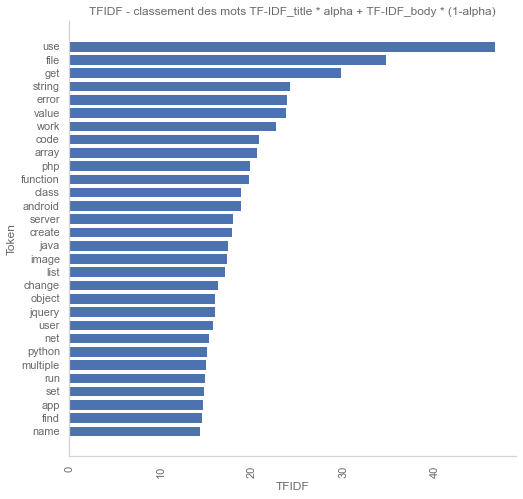

In [24]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(N).index,sortedTFIDFCommon.head(N).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("TFIDF - classement des mots TF-IDF_title * alpha + TF-IDF_body * (1-alpha)")
plt.show()

In [25]:
X=dfTFIDFCommon.values
X.shape

(2000, 2296)

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


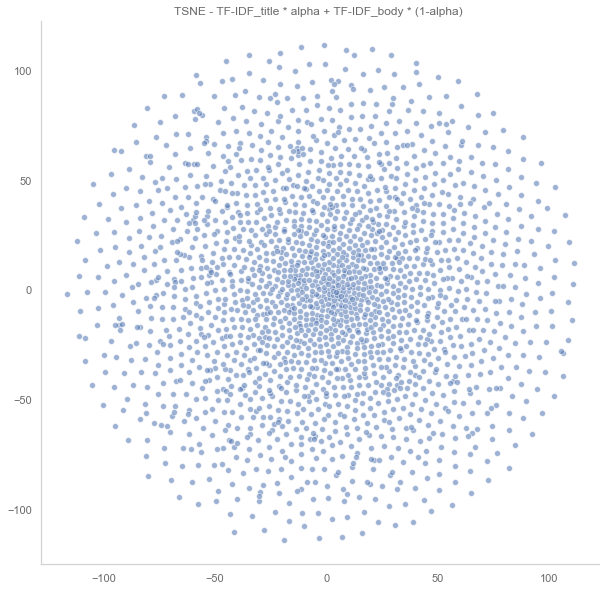

In [26]:
#%%time
tsne = TSNE(random_state=1, method='barnes_hut',n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) ')
plt.show()

### Bodies+titles

In [27]:
%%time
response= vectorizer.fit_transform(bodies_titles)
dfTFIDF_bodies_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies_titles=dfTFIDF_bodies_titles.sum(axis=0).sort_values(ascending=False)

CPU times: user 404 ms, sys: 66 ms, total: 470 ms
Wall time: 358 ms


[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - bodies_titles - classement des mots')]

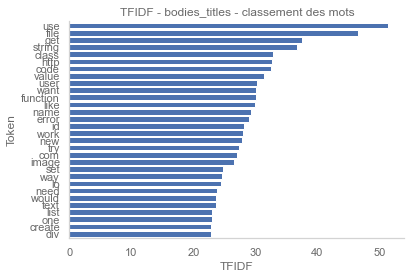

In [28]:
ax = sortedTFIDF_bodies_titles.head(N).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - bodies_titles - classement des mots')

Le calcul de TFIDF sur les corps et titres de message concaténés donne le même classement que pour le TFIDF sur les corps seuls.  
On preferera donc le TFIDF pondéré sur les titres et corps: TF-IDF_title * alpha + TF-IDF_body * (1-alpha).

In [29]:
X=dfTFIDF_bodies_titles.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


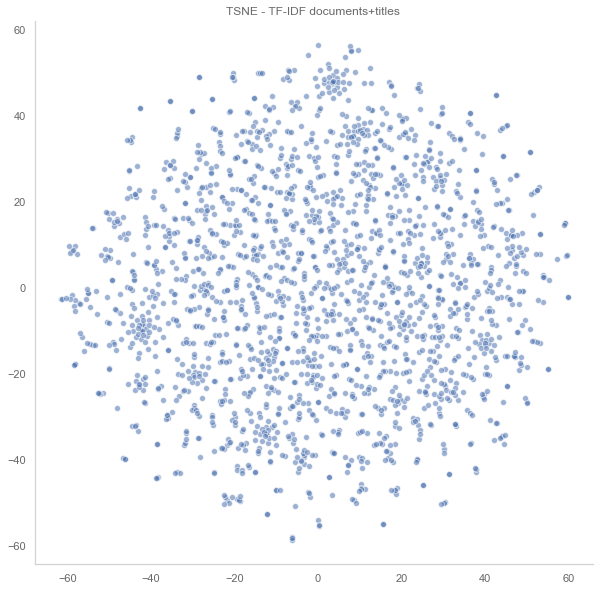

In [30]:
#%%time
tsne = TSNE(random_state=1, method='barnes_hut',n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF documents+titles ')
plt.show()

des regroupements semblent apparaitre sur la visualisation TSNE, voyons le score de silhouette/nombre de clusters obtenu par clustering K-Means

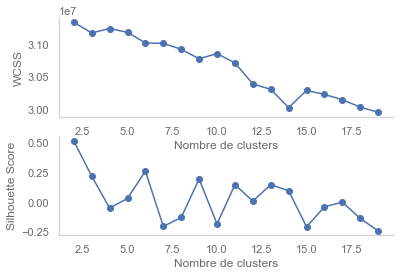

CPU times: user 9min 34s, sys: 8.39 s, total: 9min 42s
Wall time: 53.8 s


In [31]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(XCentreReduit)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(XCentreReduit,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

Le score de silhouette <0.25 au dela de 2 clusters.  
Le clustering KMeans n'est pas concluant pour les titres et corps de messages concaténés.

## REDUCTION DIMENSIONNELLE - ACP

<AxesSubplot:>

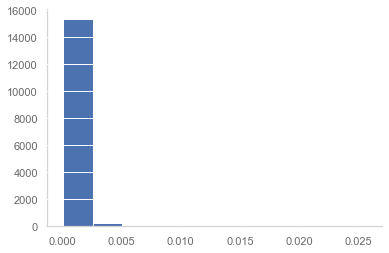

In [32]:
dfTFIDF_bodies_titles.mean(axis=0).hist()

La distribution des scores TFIDF est concentrée entre les valeurs 0 et 0.0025

In [33]:
# on ne garde que les token avec des TDFIDF significatif (>0.5)
df=dfTFIDFCommon[(dfTFIDFCommon.fillna(0))>0.01].fillna(0)
df.describe()

,split,bind,hover,marker,picker,nhibernate,syntax,page,store,jar,nil,chartview,keyboard,anything,ffmpeg,quit,item,terraform,width,transform,sharepoint,mvvm,differentiate,info,enum,...,ientitycollection,lite,java,cran,title,transcoding,coverage,jbutton,gwt,injection,iwindowsformseditorservice,good,ascii,flow,layer,partially,union,username,translation,pattern,switch,testlistener,app,tee,argsort
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.001120,0.000786,0.000508,0.000514,0.000314,0.000595,0.001763,0.006778,0.003865,0.000776,0.000430,0.000231,0.000628,0.000959,0.000294,0.000316,0.004486,0.000543,0.002616,0.000361,0.000764,0.000563,0.000147,0.001103,0.000458,...,0.000235,0.000145,0.008611,0.000299,0.001446,0.000203,0.000273,0.000235,0.000306,0.000141,0.000197,0.001762,0.000244,0.000434,0.000882,0.000237,0.000604,0.001025,0.000313,0.001621,0.001009,0.000265,0.007087,0.000196,0.000254
std,0.019069,0.015399,0.013482,0.010881,0.007706,0.015398,0.027016,0.040018,0.032375,0.015757,0.009278,0.010313,0.015650,0.013573,0.010098,0.011825,0.035594,0.017338,0.025607,0.011554,0.018497,0.016103,0.005993,0.014889,0.014725,...,0.010522,0.006497,0.047343,0.012530,0.016539,0.009056,0.011557,0.010509,0.011086,0.006026,0.008804,0.020434,0.009175,0.010804,0.015422,0.010609,0.014297,0.016977,0.013002,0.023234,0.017421,0.011838,0.041917,0.008392,0.011364
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.457917,0.473055,0.423946,0.330733,0.319462,0.424512,0.573695,0.433663,0.461028,0.434199,0.399042,0.461199,0.474231,0.439533,0.432988,0.526962,0.548232,0.619800,0.434596,0.512549,0.546969,0.527019,0.266667,0.447118,0.587305,...,0.470578,0.2

In [34]:
dataPCA=df
dataPCA.info(),dataPCA.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2296 entries, split to argsort
dtypes: float64(2296)
memory usage: 35.0 MB


(None,
 Index(['split', 'bind', 'hover', 'marker', 'picker', 'nhibernate', 'syntax',
        'page', 'store', 'jar',
        ...
        'partially', 'union', 'username', 'translation', 'pattern', 'switch',
        'testlistener', 'app', 'tee', 'argsort'],
       dtype='object', length=2296))

In [35]:
X=dataPCA.values
variables=dataPCA.columns # Variables

In [36]:
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)
XCentreReduit.shape

(2000, 2296)

In [37]:
n_comp=1700 # n_comp <= nombre de variables
pca = decomposition.PCA(n_components=n_comp)
pca.fit(XCentreReduit)

PCA(n_components=1700)

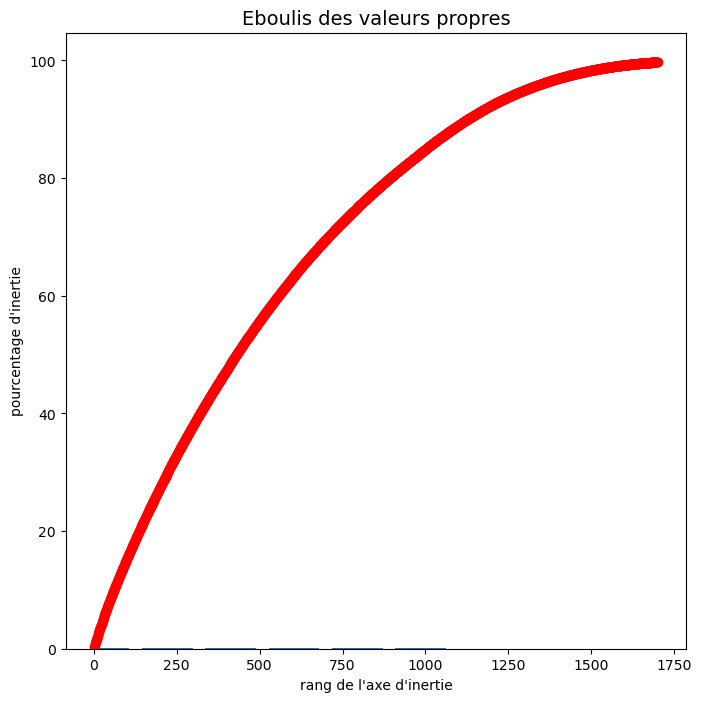

In [38]:
plt.style.use('default')
# taille du schema
plt.rcParams["figure.figsize"] = (8,8)

vectVarianceExpliquee = pca.explained_variance_ratio_*100 # renvoie les variences expliquées pour chacune des dimensions
plt.bar(np.arange(len(vectVarianceExpliquee))+1, vectVarianceExpliquee)
plt.plot(np.arange(len(vectVarianceExpliquee))+1, vectVarianceExpliquee.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres",fontsize=14,fontweight='normal')
plt.show()

In [39]:
composantesPrincipales = pca.components_ # triés par variance expliquée

In [40]:
# Selection du plan Factoriel
#dimension 1
d1=0
#dimension 2
d2=1

<timed exec>:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


CPU times: user 44.6 ms, sys: 5.06 ms, total: 49.7 ms
Wall time: 45.7 ms


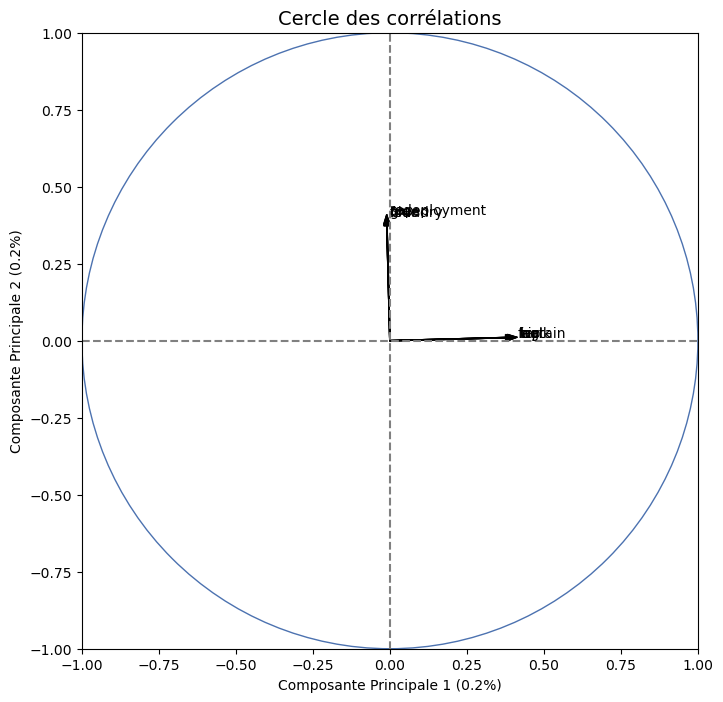

In [41]:
%%time
plt.style.use('default')
# taille du schema
plt.rcParams["figure.figsize"] = (8,8)

fig, ax = plt.subplots()

# configuration de la bordure
plt.xlim(-1,1)
plt.ylim(-1,1)

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# libelles des axes
plt.xlabel('Composante Principale {} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
plt.ylabel('Composante Principale {} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
plt.title('Cercle des corrélations',color="black",fontsize=14,fontweight='normal')
# afficher le cercle
cercle = plt.Circle((0,0),radius=1, color='b', fill=False)
ax.set_aspect(1)
ax.add_patch(cercle)

    
#placement des étiquettes des p variables + fleches (partant du centre vers les points projetés)
for i in range(len(variables)):
    p=np.array([composantesPrincipales[d1][i],composantesPrincipales[d2][i]])
    # on utilise la distance euclidienne pour n'afficher les labels que pour les individus loin du centre
    distance= np.linalg.norm(p-np.array([0,0]))        
    if distance>0.35:
        plt.annotate(variables[i],xy =(composantesPrincipales[d1][i],composantesPrincipales[d2][i]),xytext =(composantesPrincipales[d1][i]+0.01,composantesPrincipales[d2][i]),arrowprops=dict(arrowstyle="-",
                                connectionstyle="arc3")) 
        plt.arrow(0,0,composantesPrincipales[d1][i],composantesPrincipales[d2][i].astype(np.float),length_includes_head=True,head_width=0.02, head_length=0.03,color="black")

In [42]:
composantesPrincipales[d1]

array([ 0.00012438, -0.00070381, -0.00054932, ..., -0.00322075,
       -0.00043939, -0.00014977])

In [43]:
X.shape,composantesPrincipales[d1].shape,composantesPrincipales[d2].shape

((2000, 2296), (2296,), (2296,))

In [44]:
composantesPrincipales

array([[ 1.24378770e-04, -7.03809984e-04, -5.49315997e-04, ...,
        -3.22075138e-03, -4.39387080e-04, -1.49769286e-04],
       [-1.53009484e-03, -2.02444564e-03,  1.85837662e-03, ...,
        -2.37876624e-03, -1.12194918e-03, -7.08286993e-04],
       [-2.30150923e-03, -2.16298431e-03, -1.75310239e-03, ...,
         4.66084292e-04, -1.33925997e-03, -1.03248032e-03],
       ...,
       [-2.03747986e-02, -7.73824802e-03,  1.56388885e-02, ...,
        -5.05466888e-02, -7.52413890e-03,  2.34362980e-02],
       [ 8.07538596e-05,  2.10619699e-02,  1.90889505e-03, ...,
        -4.96971097e-02, -4.44739667e-03, -3.81787364e-02],
       [ 6.17128058e-03, -1.81191670e-02, -4.87855116e-02, ...,
        -2.05664849e-02, -1.89652982e-02,  9.95692470e-03]])

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


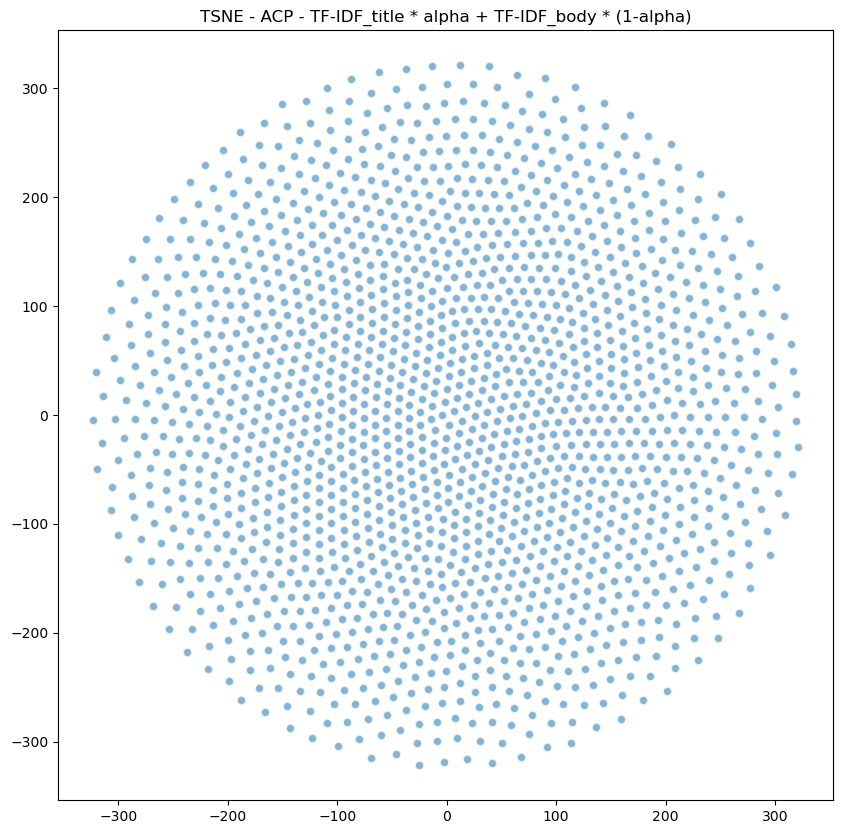

In [45]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(composantesPrincipales)
tsne_results.shape

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - ACP - TF-IDF_title * alpha + TF-IDF_body * (1-alpha)')
plt.show()

## CLUSTERING

In [46]:
X=df.values

### KMeans

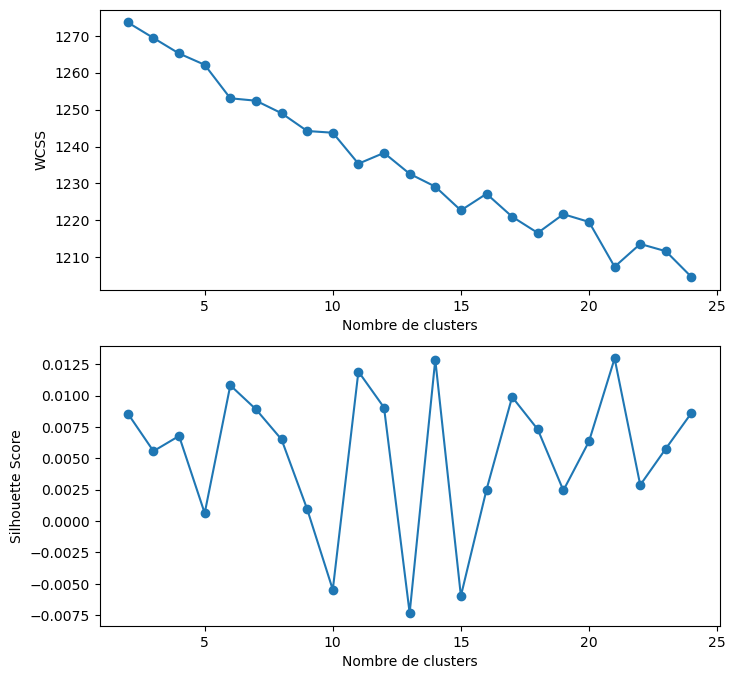

In [47]:
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]

for n in range(2,25):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,25), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,25), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Bi-grams

In [102]:
# application de TF IDF de scikit learn sur le document
pd.options.display.max_colwidth=1000
pd.options.display.max_columns=80

vectorizer= TfidfVectorizer(ngram_range = (2,2))

In [103]:
response= vectorizer.fit_transform(bodies)
dfTFIDF_bodies=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies=dfTFIDF_bodies.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF Bigrams - bodies - classement des mots')]

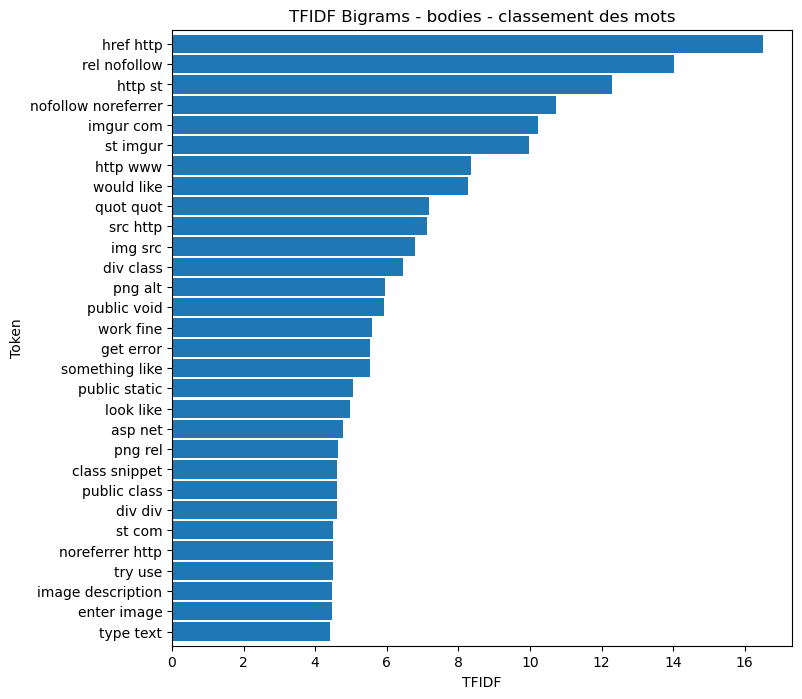

In [104]:
ax = sortedTFIDF_bodies.head(N).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF Bigrams - bodies - classement des mots')

In [105]:
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF Bigrams - titles - classement des mots')]

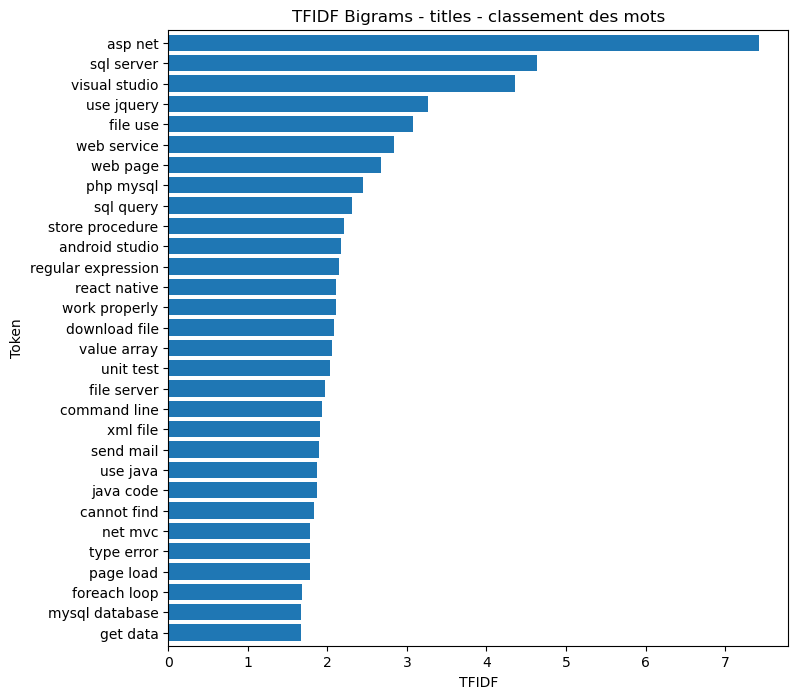

In [106]:
ax = sortedTFIDF_titles.head(N).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF Bigrams - titles - classement des mots')

In [107]:
response= vectorizer.fit_transform(bodies_titles)
dfTFIDF_bodies_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies_titles=dfTFIDF_bodies_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF Bigrams - bodies+titles - classement des mots')]

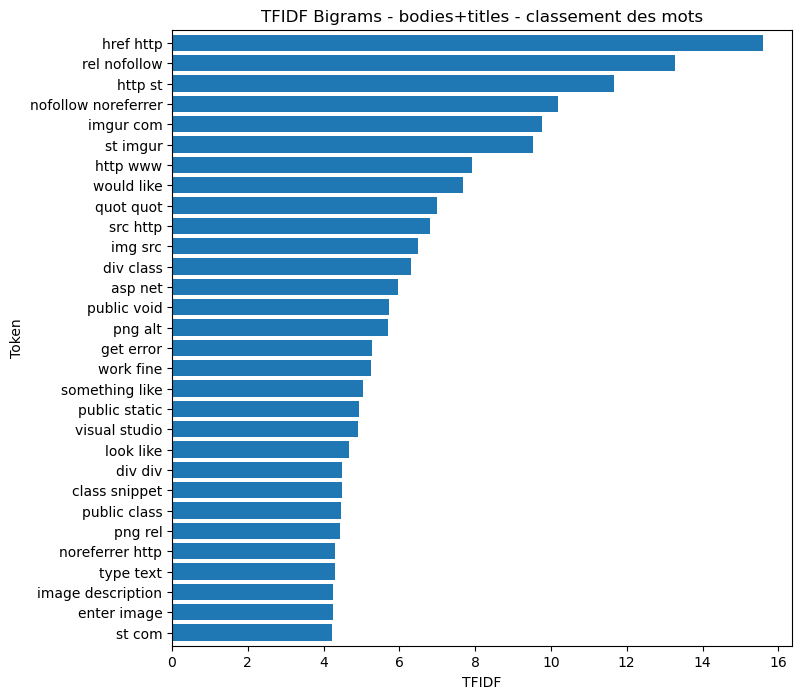

In [108]:
ax = sortedTFIDF_bodies_titles.head(N).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF Bigrams - bodies+titles - classement des mots')

In [109]:
X=dfTFIDF_bodies_titles.values

In [110]:
joblib.dump(dfTFIDF_bodies_titles,'dfTFIDF_bodies_titles.jbl.bz2')

['dfTFIDF_bodies_titles.jbl.bz2']

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


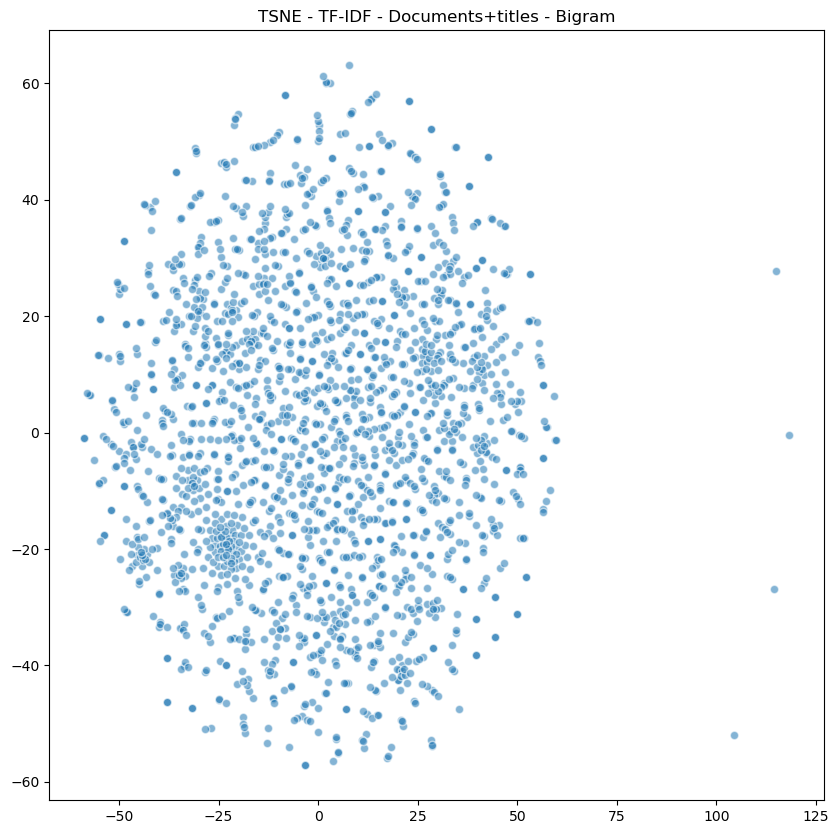

In [57]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF - Documents+titles - Bigram')
plt.show()

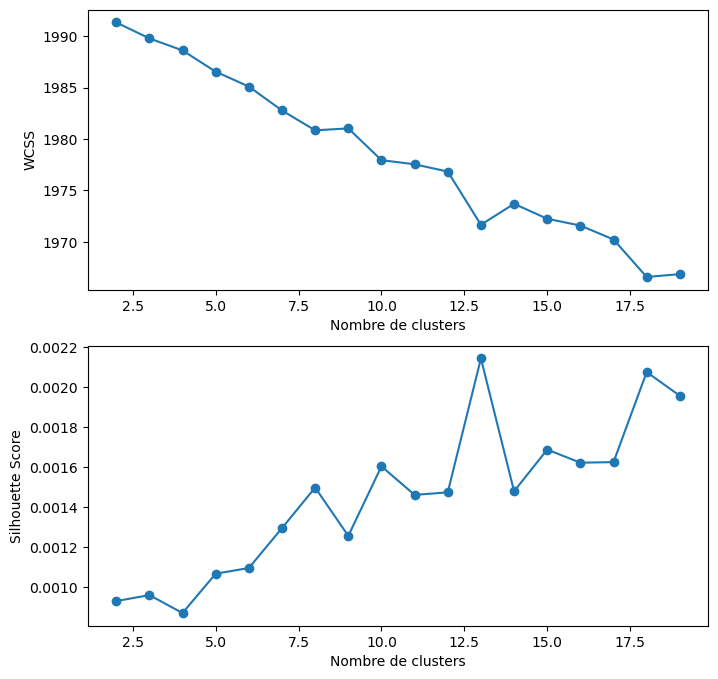

CPU times: user 3h 8min 47s, sys: 2min 24s, total: 3h 11min 12s
Wall time: 22min 1s


In [58]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
#centreReduit = preprocessing.StandardScaler().fit(X)
#XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [111]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_bodies.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_bodies[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

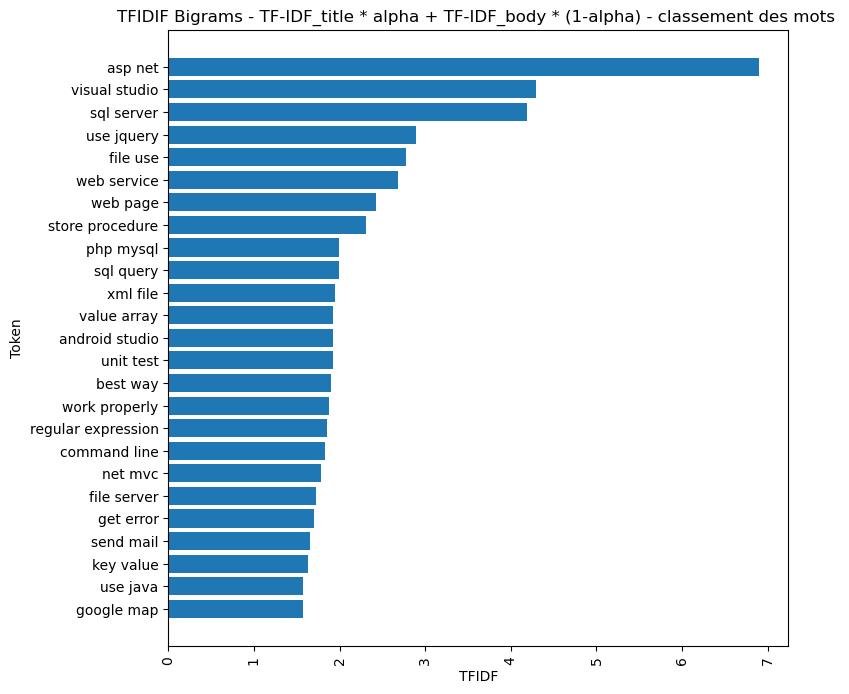

In [112]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(25).index,sortedTFIDFCommon.head(25).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("TFIDIF Bigrams - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - classement des mots ")
plt.show()

In [113]:
X=dfTFIDFCommon.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


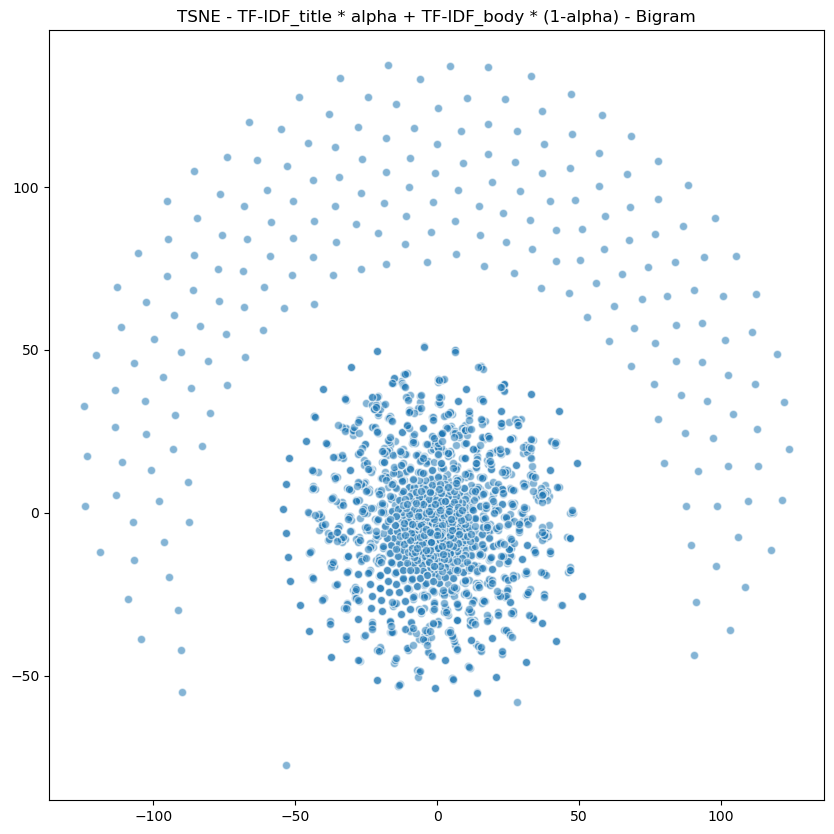

In [62]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - Bigram')
plt.show()

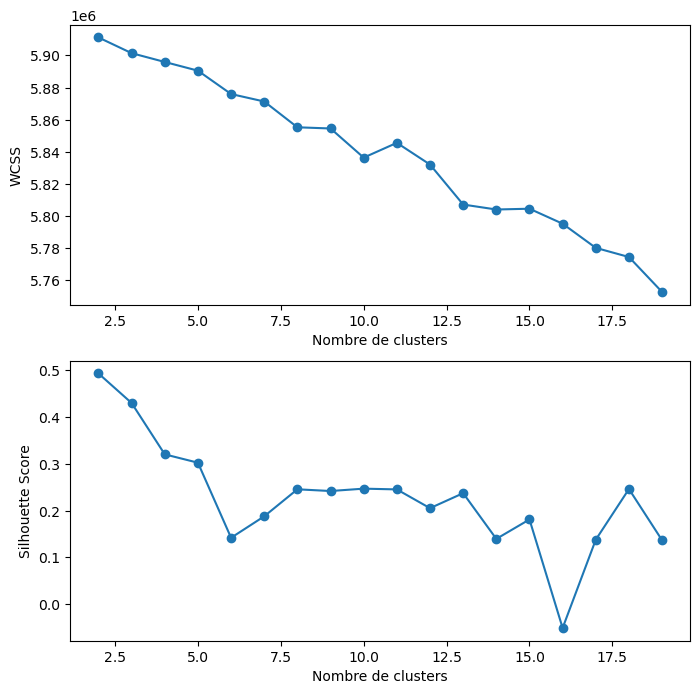

CPU times: user 2min 13s, sys: 1.65 s, total: 2min 15s
Wall time: 11.6 s


In [63]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]
centreReduit = preprocessing.StandardScaler().fit(X)
XCentreReduit = centreReduit.transform(X)

for n in range(2,20):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(XCentreReduit)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(XCentreReduit,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [114]:
joblib.dump(dfTFIDFCommon,'dfTFIDFCommon.jbl.bz2')

['dfTFIDFCommon.jbl.bz2']

# Tri-grams

In [65]:
%%time
# application de TF IDF de scikit learn sur le document
pd.options.display.max_colwidth=1000
pd.options.display.max_columns=80

vectorizer= TfidfVectorizer(ngram_range = (3,3))



CPU times: user 3.4 ms, sys: 2.93 ms, total: 6.33 ms
Wall time: 6.31 ms


In [66]:
response= vectorizer.fit_transform(bodies)
dfTFIDF_bodies=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies=dfTFIDF_bodies.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TDFIDF Trigrams - bodies - classement des mots')]

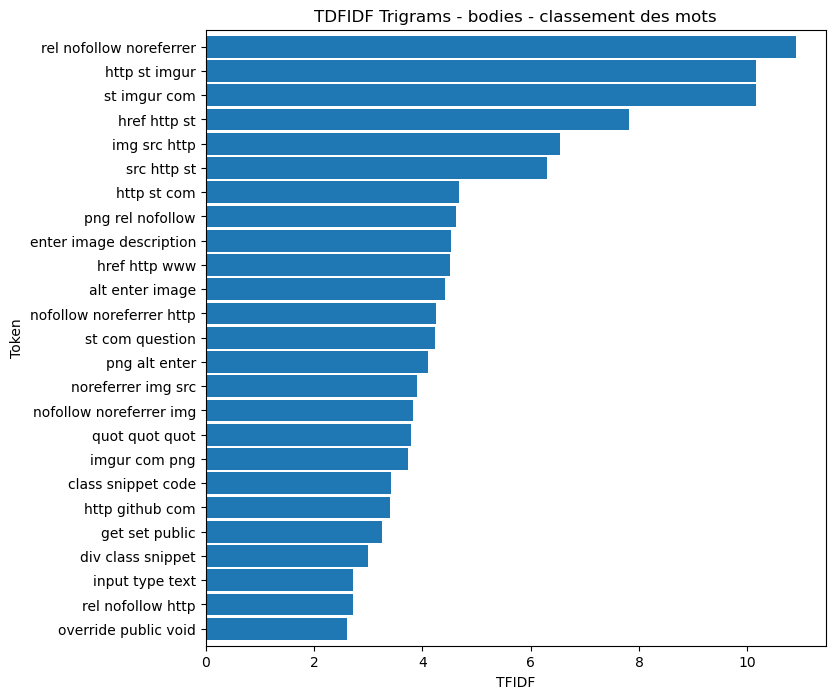

In [67]:
ax = sortedTFIDF_bodies.head(25).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TDFIDF Trigrams - bodies - classement des mots')

In [68]:
response= vectorizer.fit_transform(titles)
dfTFIDF_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_titles=dfTFIDF_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TDFIDF Trigrams - classement des mots')]

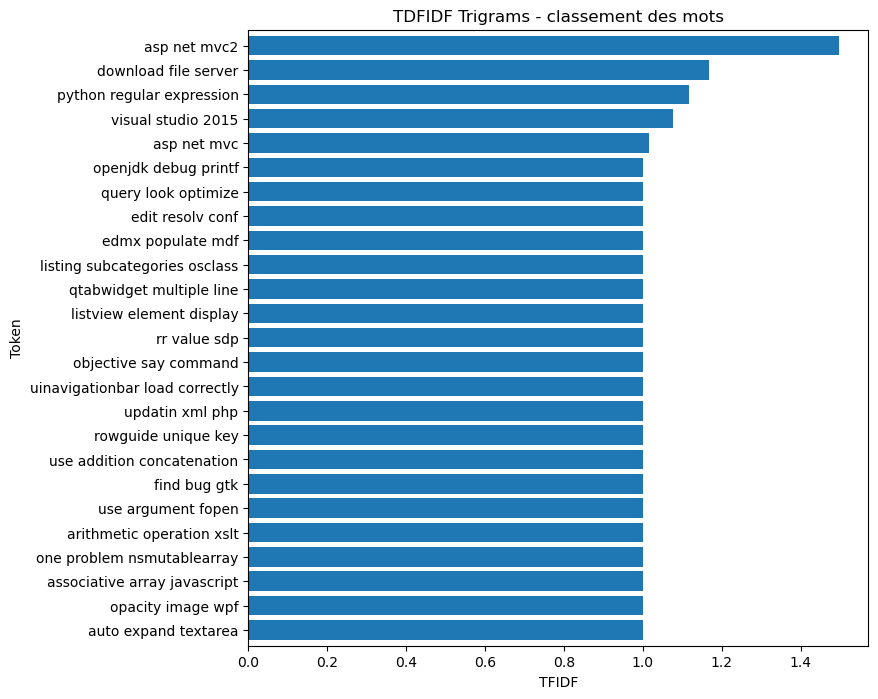

In [69]:
ax = sortedTFIDF_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TDFIDF Trigrams - classement des mots')

In [70]:
response= vectorizer.fit_transform(bodies_titles)
dfTFIDF_bodies_titles=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_bodies_titles=dfTFIDF_bodies_titles.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TDFIDF Trigram - bodies+titles - classement des mots')]

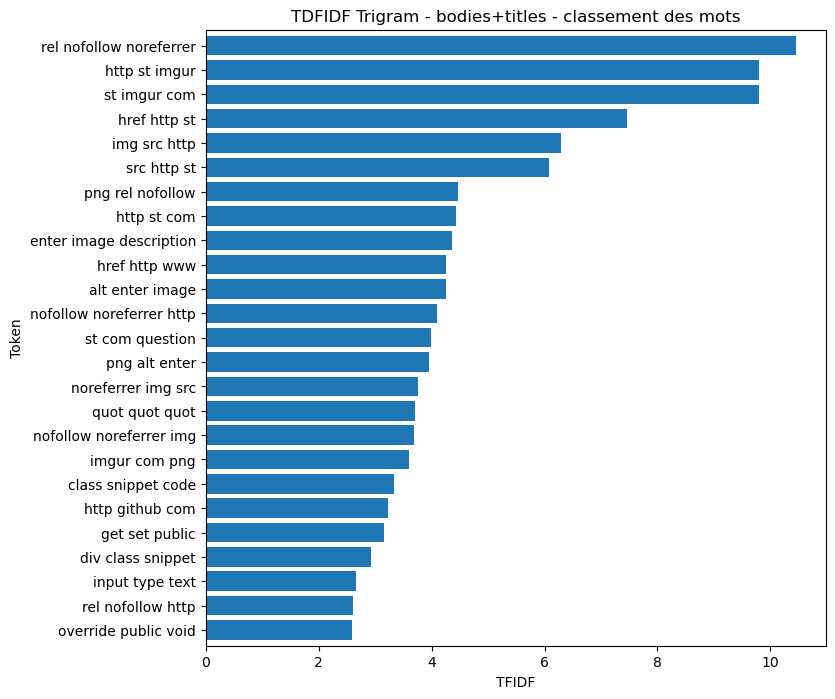

In [71]:
ax = sortedTFIDF_bodies_titles.head(25).plot(kind='barh', width=0.80)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TDFIDF Trigram - bodies+titles - classement des mots')

In [72]:
X=dfTFIDF_bodies_titles.values

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


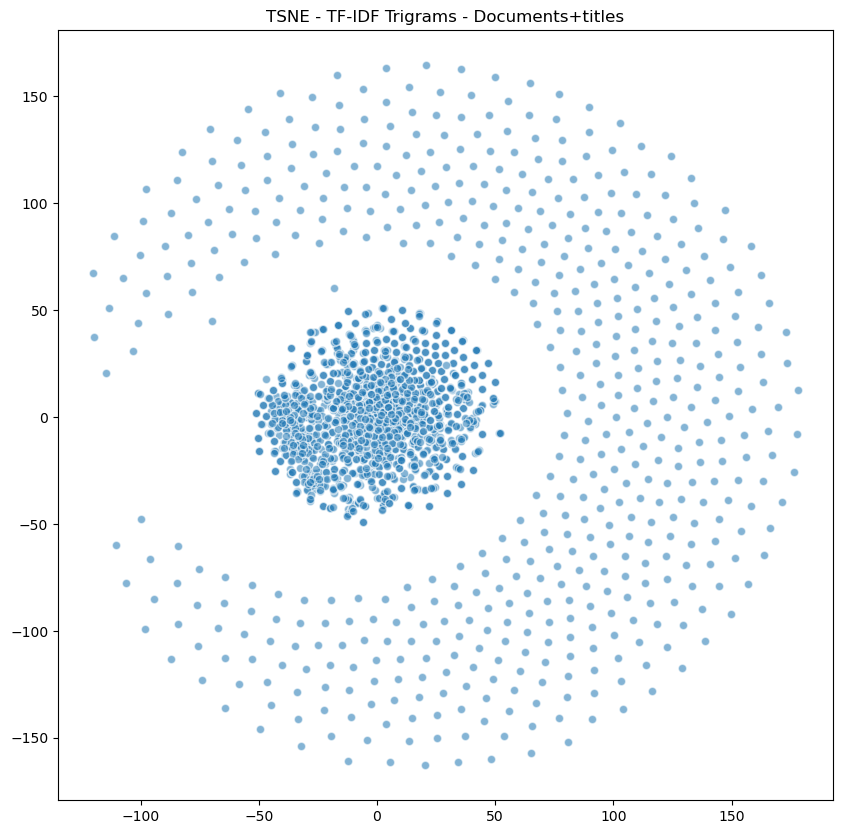

In [73]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)
tsne_results.shape

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - TF-IDF Trigrams - Documents+titles')
plt.show()

In [74]:
X.shape

(2000, 162819)

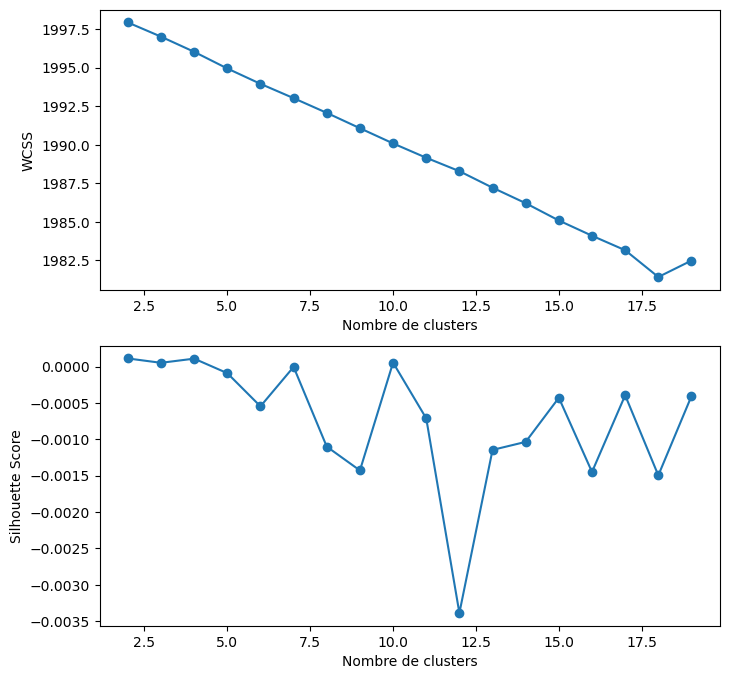

CPU times: user 32min 55s, sys: 57.3 s, total: 33min 52s
Wall time: 3min 7s


In [75]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]

for n in range(2,20):
    cl = cluster.MiniBatchKMeans(n_clusters=n, batch_size=10)# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [76]:
commonTokens=list(set(dfTFIDF_titles.columns) & set(dfTFIDF_bodies.columns))
dfTFIDFCommon=dfTFIDF_titles[0:10000][commonTokens]*0.8+dfTFIDF_bodies[0:10000][commonTokens]*0.2
sortedTFIDFCommon=dfTFIDFCommon.sum(axis=0).sort_values(ascending=False)

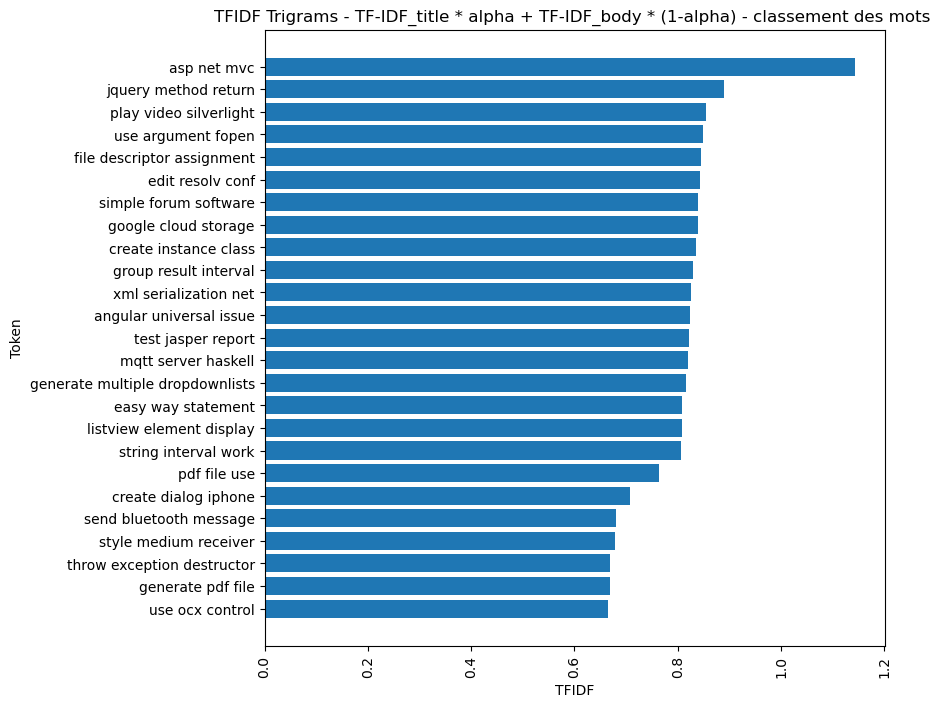

In [77]:
plt.figure(figsize=(8,8))

plt.barh(sortedTFIDFCommon.head(25).index,sortedTFIDFCommon.head(25).values)
plt.gca().invert_yaxis()

plt.xlabel("TFIDF")
plt.xticks(rotation='vertical')

plt.ylabel("Token")
plt.title("TFIDF Trigrams - TF-IDF_title * alpha + TF-IDF_body * (1-alpha) - classement des mots ")
plt.show()

In [78]:
X=dfTFIDFCommon

/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/hui-guan/opt/miniconda3/envs/python3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


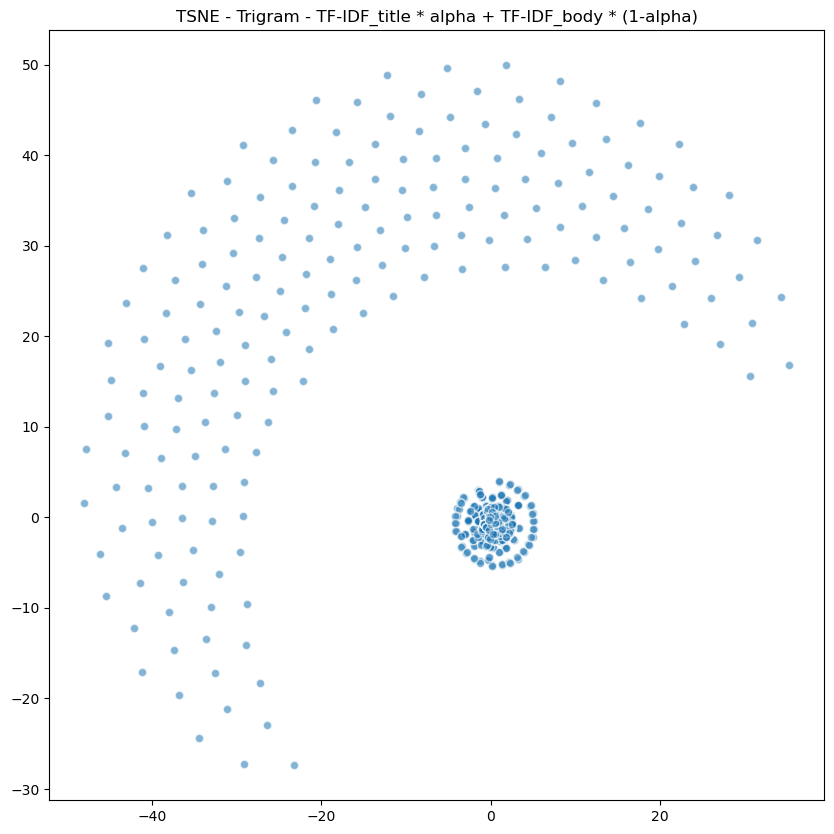

In [79]:
#%%time
tsne = TSNE(random_state=1, n_jobs=2,n_iter=1000, n_components = 2)
tsne_results = tsne.fit_transform(X)

# graph TSNE
plt.figure(figsize = (10,10))


plt.scatter(tsne_results[:,0],tsne_results[:,1], edgecolor = "white", alpha=0.55)
plt.title('TSNE - Trigram - TF-IDF_title * alpha + TF-IDF_body * (1-alpha)')
plt.show()

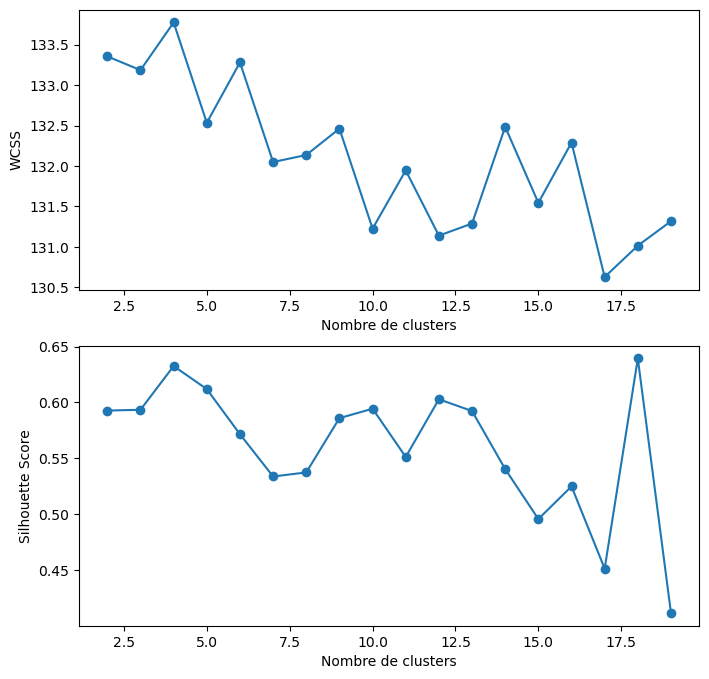

CPU times: user 24.8 s, sys: 2.05 s, total: 26.9 s
Wall time: 2.66 s


In [80]:
%%time
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]

for n in range(2,20):
    cl = cluster.MiniBatchKMeans(n_clusters=n, batch_size=10)# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,20), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,20), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Tags

In [94]:
tags=dfCleaned['Tags'].map(''.join)
tags

43576                                  c#  custom-controls  propertygrid  inplace-editing 
24783                                                      javascript  jquery  codemirror 
27941                                                      php  mysql  zend-search-lucene 
31045                                                                  javascript  jquery 
11525                                                 symfony  session  cookies  samesite 
35342                                                                 php  iis-7  caching 
5189                                                                angular  ng-bootstrap 
33560                                                                         c#  casting 
17916                                                                             jsf  el 
45286                                                               c#  screenshot  frame 
17193          azure-devops  azure-pipelines  azure-pipelines-tasks  azure-pipelines-yaml 

## Classement TF-IDF

In [95]:
vectorizer= TfidfVectorizer()

In [96]:
response= vectorizer.fit_transform(tags)
dfTFIDF_tags=pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names_out())
sortedTFIDF_tags=dfTFIDF_tags.sum(axis=0).sort_values(ascending=False)

[Text(0.5, 0, 'TFIDF'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'TFIDF - tags - classement des mots')]

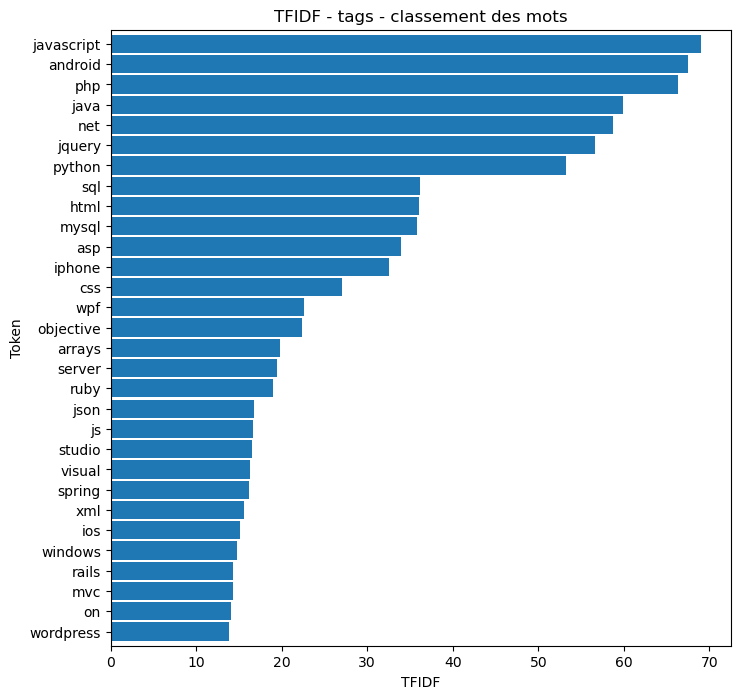

In [97]:
ax = sortedTFIDF_tags.head(N).plot(kind='barh', width=0.90)
ax.invert_yaxis()
ax.set(xlabel='TFIDF', ylabel='Token', title='TFIDF - tags - classement des mots')

## Labellisation

In [98]:
# correspondance Tag -> classe (1->20)
tagclass=sortedTFIDF_tags.head(N).to_dict()
for i, k in enumerate(tagclass):
    tagclass[k]=i+1
tagclass

{'javascript': 1,
 'android': 2,
 'php': 3,
 'java': 4,
 'net': 5,
 'jquery': 6,
 'python': 7,
 'sql': 8,
 'html': 9,
 'mysql': 10,
 'asp': 11,
 'iphone': 12,
 'css': 13,
 'wpf': 14,
 'objective': 15,
 'arrays': 16,
 'server': 17,
 'ruby': 18,
 'json': 19,
 'js': 20,
 'studio': 21,
 'visual': 22,
 'spring': 23,
 'xml': 24,
 'ios': 25,
 'windows': 26,
 'rails': 27,
 'mvc': 28,
 'on': 29,
 'wordpress': 30}

In [99]:
joblib.dump(tagclass,'tagclass.jbl.bz2')

['tagclass.jbl.bz2']

Voici les N tags les plus utilisés.
Que nous utiliserons comme target.

In [116]:
# filtrage des colonnes du dataset contenant les tags
cols=[]
for i,k in enumerate(tagclass):
    regexstring='.*'+k+'.*' # on recherche les chaines contenant le tag k
    cols = cols+[c for c in dfTFIDFCommon.columns if re.match(regexstring,c.lower())] # si le tag est trouvé on ajoute la colonne à notre liste de colonnes à conserver
cols=list(set(cols))

In [117]:
dfTFIDFCommonTarget=dfTFIDFCommon[cols]
dfTFIDFCommonTarget.sample(8)

,problem sql,connect mysql,html form,php multidimensional,div content,convert one,get server,value contains,component equal,search android,one change,click javascript,ljava lang,content source,java web,html twig,connection server,profile function,show second,app icon,php api,content use,another html,console component,someone age,value dictionary,function extern,define conversion,array php,android webview,integration test,ocx control,convert string,pecl php,jquery like,session id,change php,client session,send response,div contains,...,key one,content scroll,possible solution,online code,restcontroller method,string contains,class function,name convention,url jsp,console program,file server,anyone explain,ui virtualization,multidimensional array,link one,constant storage,define python,arithmetic operation,php build,ajax php,library ruby,sql query,parse xml,content type,exception org,tzinfo timezone,performance comparison,config file,use java,instance ironpython,java code,work sql,first one,control tree,nest json,revision number,nest exception,visual web,use python,net remoting
1636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
joblib.dump(dfTFIDFCommonTarget,'dfTFIDFCommonTarget.jbl.bz2')

['dfTFIDFCommonTarget.jbl.bz2']

In [93]:
elapsed=time.time() - start
elapsed

1717.7608759403229